#### Necessary Libraries

In [18]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from random import seed,sample
import datetime as dt
from datetime import datetime
import seaborn as sns

import scipy.stats as stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# feature scaling & OHE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler # data encoders

# moodels 
import xgboost as xgb

# evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, average_precision_score, precision_recall_curve

# resampling techniques for imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler #
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

# formatting 
%matplotlib inline
pd.set_option('display.max_columns', 500)

#### Reading Data 
- Training Datasets: X_train, y_train
- Validation Datasets: X_val, y_val

*Note: they are in a folder one level higher than current folder*

In [3]:
X_train = pd.read_csv('../X_train.csv')
X_val = pd.read_csv('../X_val.csv')
y_train = pd.read_csv('../y_train.csv')
y_val = pd.read_csv('../y_val.csv')

# test set only for one-time assessment of final model
X_test = pd.read_csv('../X_test.csv')
y_test = pd.read_csv('../y_test.csv')

In [4]:
X_train.head()

,hour_of_day,day_of_week,category,gender,age_group,state,job_category,distance,amount(usd)
0,15,Monday,kids_pets,F,21-40,NY,C2,52.770575,75.72
1,10,Tuesday,gas_transport,F,41-60,CA,C2,68.181551,79.74
2,20,Monday,home,M,41-60,MT,C4,66.904380,74.92
3,0,Saturday,gas_transport,F,0-20,IL,C2,65.195819,44.30
4,18,Saturday,home,M,41-60,MD,C2,71.833218,28.02


In [5]:
print("X_train's Shape:",X_train.shape)
print("X_val's Shape:",X_val.shape)
print("X_test's Shape:",X_test.shape)

X_train's Shape: (1481915, 9)
X_val's Shape: (185239, 9)
X_test's Shape: (185240, 9)


#### Local Preprocessing

Creating a **Pipeline*** for the following preprocessing steps:
- Feature Scaling for Numerical Features
- One-Hot Encoding for Categorical Features

****Pipeline()** helps to streamline processes especially since we are refining our models using different techniques like under/oversampling, hyperparameter tuning, etc.*

In [6]:
# numerical features - StandardScaler()
numerical_cols = ['hour_of_day', 'distance', 'amount(usd)']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


# categorical features - OneHotEncoder()
categorical_cols = ['day_of_week', 'category', 'gender','age_group', 'state', 'job_category']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# combining preprocessing pipelines for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

#### Helper Functions for Evaluating Model Performance 
a. Evaluate Model using Recall, Precision, F1, Accuracy, ROC AUC, PR AUC

b. Confusion Matrix showing TP,FP,TN,FN

In [7]:
def evaluate_model(y_true, y_pred, y_pred_prob, model_name):
    metrics = {
        'Recall':recall_score(y_true, y_pred),
        'Precision':precision_score(y_true, y_pred),
        'F1 Score':f1_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_pred_prob),
        'PR AUC': average_precision_score(y_true, y_pred_prob) # precision-recall AUC
}

    metrics_df = pd.DataFrame([metrics], index =[model_name])
    return metrics_df

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(model_name)
    plt.show()

#### 1. Baseline Model for XGBoost

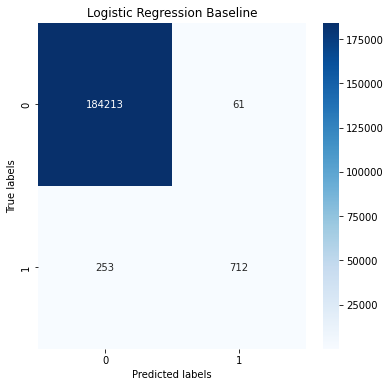

In [8]:
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

base_model.fit(X_train, y_train)

y_val_pred = base_model.predict(X_val)
y_val_pred_prob = base_model.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='Logistic Regression Baseline')

In [9]:
base_model_results = evaluate_model(y_true=y_val,
                                    y_pred=y_val_pred, 
                                    y_pred_prob=y_val_pred_prob,
                                    model_name='XGBoost Baseline')
base_model_results

,Recall,Precision,F1 Score,Accuracy,ROC AUC,PR AUC
XGBoost Baseline,0.737824,0.921087,0.819333,0.998305,0.997758,0.886572


Insights

#### 2. Addressing Class Imbalance 
**a. Synthetic Minority Over-sampling Technique (SMOTE)**

Since our dataset exhibits significant class imbalance (i.e. non-fraudulent >> fraudulent transactions), this can lead to a model being biased towards the majority class, often resulting in poor detection of the minority class (i.e. fraudulent transactions). 

Unlike random oversampling, SMOTE generates synthetic samples rather than simply duplicating existing ones. This approach helps in creating a more diverse and representative sample of the minority class, potentially leading to better generalization Thereby aiding the model in learning patterns specific to fraudulent transactions. Leading to higher recall/sensitivity, making the model more capable of detecting actual fraud cases.

ImbPipeline allows inclusion of resampling step within pipeline, ensuring that resampling only happens during training phase


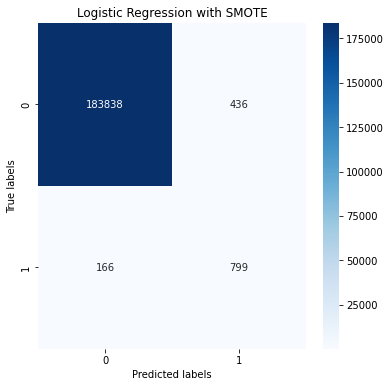

In [10]:
model_SMOTE = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

# train model_SMOTE
model_SMOTE.fit(X_train, y_train.values.ravel())  # ensures y_train is in the correct format

# Predict on the validation set
y_val_pred = model_SMOTE.predict(X_val)
y_val_pred_prob = model_SMOTE.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='Logistic Regression with SMOTE')

In [11]:
model_SMOTE_results = evaluate_model(y_true=y_val,
                             y_pred=y_val_pred, 
                             y_pred_prob=y_val_pred_prob,
                             model_name='XGBoost with SMOTE')
model_SMOTE_results

,Recall,Precision,F1 Score,Accuracy,ROC AUC,PR AUC
XGBoost with SMOTE,0.827979,0.646964,0.726364,0.99675,0.996076,0.848459


In [12]:
results_df = pd.concat([base_model_results, model_SMOTE_results],axis=0)
results_df

,Recall,Precision,F1 Score,Accuracy,ROC AUC,PR AUC
XGBoost Baseline,0.737824,0.921087,0.819333,0.998305,0.997758,0.886572
XGBoost with SMOTE,0.827979,0.646964,0.726364,0.996750,0.996076,0.848459


Much Higher Recall (78.86%): The model now catches a significantly higher proportion of fraud cases.

Low Precision (3.42%): A large number of false positives, as many legitimate transactions are incorrectly flagged as fraud.

Low F1 Score (6.56%): Despite the high recall, the F1 is still low due to very low precision.

Lower Accuracy (88.29%): Reflects the increase in false positives.

Higher ROC AUC (91.99%): Indicates better overall performance in distinguishing classes.

Lower PR AUC (14.63%): Reflects the precision-recall trade-off; higher recall but much lower precision.

**Analysis**:

The introduction of SMOTE has significantly improved the model's ability to detect fraud (as seen in the increased recall), which is crucial in fraud detection. However, this has come at the cost of a large number of false positives (lower precision).

The high number of false positives has reduced the overall accuracy and impacted the F1 score.
The improvement in ROC AUC suggests better discrimination between classes, but the drop in PR AUC indicates issues with precision-recall balance, which is more critical in imbalanced datasets.

**b. Random Undersampling**


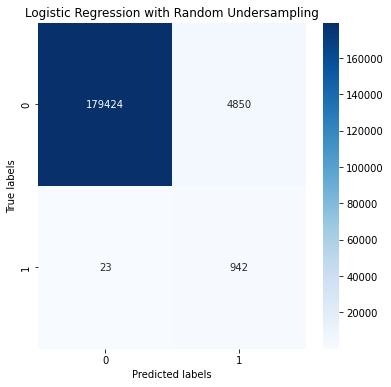

In [13]:
model_RUS = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

# train model_RUS
model_RUS.fit(X_train, y_train.values.ravel())  # ensures y_train is in the correct format

# Predict on the validation set
y_val_pred = model_RUS.predict(X_val)
y_val_pred_prob = model_RUS.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='Logistic Regression with Random Undersampling')

In [16]:
model_RUS_results = evaluate_model(y_true=y_val,
                             y_pred=y_val_pred, 
                             y_pred_prob=y_val_pred_prob,
                             model_name='XGBoost with Random Undersampling')
model_RUS_results

,Recall,Precision,F1 Score,Accuracy,ROC AUC,PR AUC
XGBoost with Random Undersampling,0.976166,0.162638,0.278822,0.973693,0.997167,0.795118


In [17]:
results_df = pd.concat([results_df, model_RUS_results],axis=0)
results_df

,Recall,Precision,F1 Score,Accuracy,ROC AUC,PR AUC
XGBoost Baseline,0.737824,0.921087,0.819333,0.998305,0.997758,0.886572
XGBoost with SMOTE,0.827979,0.646964,0.726364,0.996750,0.996076,0.848459
Logistic Regression with Random Undersampling,0.976166,0.162638,0.278822,0.973693,0.997167,0.795118
XGBoost with Random Undersampling,0.976166,0.162638,0.278822,0.973693,0.997167,0.795118


**d. Random Oversampling**

In [ ]:
model_ROS = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomOverSampler(random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

# train model_ROS
model_ROS.fit(X_train, y_train.values.ravel())  # ensures y_train is in the correct format

# Predict on the validation set
y_val_pred = model_ROS.predict(X_val)
y_val_pred_prob = model_ROS.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='Logistic Regression with Random Oversampling')

## 3. Hyperparamter Tuning

In [ ]:
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],  # Type of penalty
    'classifier__solver': ['liblinear', 'saga']  # Solver compatible with L1 penalty
}

a. Baseline Model

In [ ]:
grid_search = RandomizedSearchCV(base_model, param_grid, cv=5, scoring='f1_weighted', verbose=2)
grid_search.fit(X_train, y_train)

In [ ]:
est_params_baseline = grid_search.best_params_
best_model_baseline = grid_search.best_estimator_

In [ ]:
# Evaluate the best model on the validation set
y_val_pred_best_baseline = best_model_baseline.predict(X_val)
y_val_pred_prob_best_baseline = best_model_baseline.predict_proba(X_val)[:, 1]

In [ ]:
# Calculate evaluation metrics for the best model
evaluate_model(y_val, y_val_pred_best_baseline, y_val_pred_prob_best_baseline, 'Logistic Regression (Baseline) with Best Hyperparameters')


b. SMOTE 

In [ ]:
grid_search = GridSearchCV(model_SMOTE, param_grid, cv=5, scoring='f1_weighted', verbose=2)
grid_search.fit(X_train, y_train)

In [ ]:
best_params_SMOTE = grid_search.best_params_
best_model_SMOTE = grid_search.best_estimator_

In [ ]:
# Evaluate the best model on the validation set
y_val_pred_best_SMOTE = best_model_SMOTE.predict(X_val)
y_val_pred_prob_best_SMOTE = best_model_SMOTE.predict_proba(X_val)[:, 1]

In [ ]:
evaluate_model(y_val, y_val_pred_best_SMOTE, y_val_pred_prob_best_SMOTE, 'Logistic Regression (SMOTE) with Best Hyperparameters')


c. SMOTETomek

In [ ]:
grid_search = GridSearchCV(model_SMOTETomek, param_grid, cv=5, scoring='f1_weighted', verbose=2)
grid_search.fit(X_train, y_train)

In [ ]:
best_params_SMOTETomek= grid_search.best_params_
best_model_SMOTETomek = grid_search.best_estimator_

In [ ]:
# Evaluate the best model on the validation set
y_val_pred_best_SMOTETomek = best_model_SMOTETomek.predict(X_val)
y_val_pred_prob_best_SMOTETomek = best_model_SMOTETomek.predict_proba(X_val)[:, 1]

In [ ]:
evaluate_model(y_val, y_val_pred_best_SMOTE, y_val_pred_prob_best_SMOTE, 'Logistic Regression (SMOTETomek) Best Hyperparameters')

#### 3. Threshold Tuning 
default threshold for LR = 0.5

a. For Baseline Model

In [ ]:
y_val_pred_prob_baseline = base_model.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_prob_baseline)

f1_scores_baseline = 2 * (precision * recall) / (precision + recall)
f1_scores_baseline = np.nan_to_num(f1_scores_baseline) # handles division by zero

best_f1_idx = np.argmax(f1_scores_baseline) # index of highest f1 score
best_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores_baseline[best_f1_idx]

y_val_pred_adjusted_baseline = (y_val_pred_prob_baseline >= best_threshold).astype(int) # final predictions using the selected threshold

base_model_threshold_tuned = evaluate_model(y_val, y_val_pred_adjusted_baseline, y_val_pred_prob_baseline, 'Logistic Regression Baseline after Tuning Threshold')
base_model_threshold_tuned

,Recall,Precision,F1 Score,Accuracy,ROC AUC,PR AUC
Logistic Regression Baseline after Tuning Threshold,0.360622,0.576159,0.443595,0.995287,0.824493,0.24604


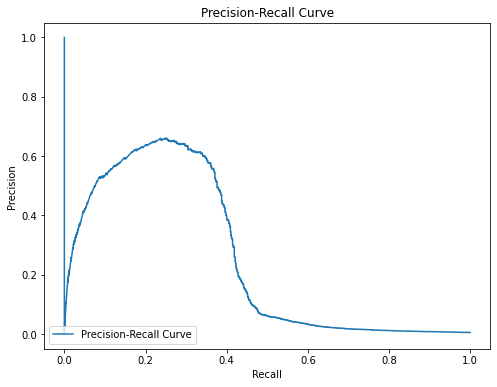

Best Threshold: 0.09031713185058289
Best F1 Score: 0.4435946462715106


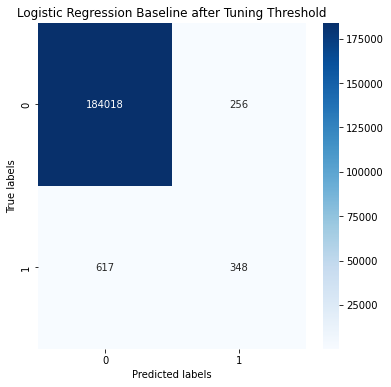

In [ ]:
# Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

plot_confusion_matrix(y_val, y_val_pred_adjusted_baseline, 'Logistic Regression Baseline after Tuning Threshold')


In [ ]:
results_df = pd.concat([results_df, base_model_threshold_tuned],axis=0)
results_df

,Recall,Precision,F1 Score,Accuracy,ROC AUC,PR AUC
Logistic Regression Baseline,0.025907,0.316456,0.047893,0.994634,0.824493,0.246040
Logistic Regression with SMOTE,0.788601,0.034201,0.065558,0.882886,0.919856,0.146274
Logistic Regression Baseline after Tuning Threshold,0.360622,0.576159,0.443595,0.995287,0.824493,0.246040


b. For SMOTE model

In [ ]:
y_val_pred_prob_smote = model_SMOTE.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_prob_smote)

f1_scores_smote = 2 * (precision * recall) / (precision + recall)
f1_scores_smote = np.nan_to_num(f1_scores_smote) # handles division by zero

best_f1_idx = np.argmax(f1_scores_smote) # index of highest f1 score
best_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores_smote[best_f1_idx]

y_val_pred_adjusted_smote = (y_val_pred_prob_smote >= best_threshold).astype(int) # final predictions using the selected threshold

smote_model_threshold_tuned = evaluate_model(y_val, y_val_pred_adjusted_smote, y_val_pred_prob_smote, 'Logistic Regression with SMOTE after Tuning Threshold')
smote_model_threshold_tuned

,Recall,Precision,F1 Score,Accuracy,ROC AUC,PR AUC
Logistic Regression with SMOTE after Tuning Threshold,0.497409,0.226202,0.310982,0.988518,0.919856,0.146274


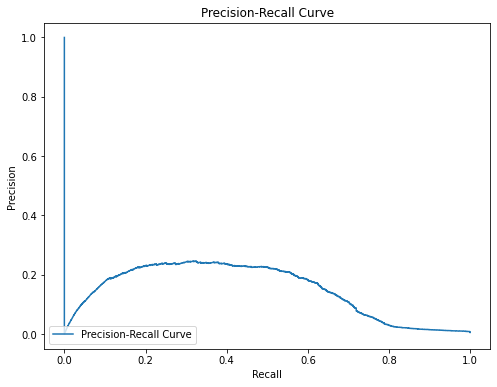

Best Threshold: 0.9340309054129825
Best F1 Score: 0.3109815354713314


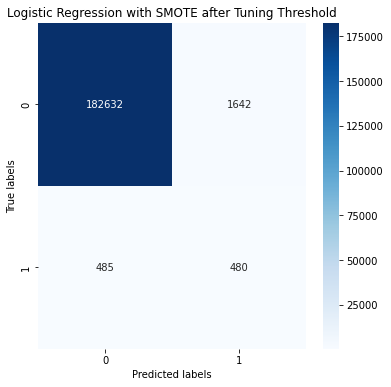

In [ ]:
# Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

plot_confusion_matrix(y_val, y_val_pred_adjusted_smote, 'Logistic Regression with SMOTE after Tuning Threshold')


update results dataframe

In [ ]:
results_df = pd.concat([results_df, smote_model_threshold_tuned],axis=0)
results_df

,Recall,Precision,F1 Score,Accuracy,ROC AUC,PR AUC
Logistic Regression Baseline,0.025907,0.316456,0.047893,0.994634,0.824493,0.246040
Logistic Regression with SMOTE,0.788601,0.034201,0.065558,0.882886,0.919856,0.146274
Logistic Regression Baseline after Tuning Threshold,0.360622,0.576159,0.443595,0.995287,0.824493,0.246040
Logistic Regression with SMOTE after Tuning Threshold,0.497409,0.226202,0.310982,0.988518,0.919856,0.146274
